In [5]:
import sklearn
print(sklearn.__version__)

1.8.0


In [6]:
# pip install -U scikit-learn

In [7]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
import joblib
import pandas as pd

# Load the saved preprocessor
preprocessor = joblib.load('insurance_preprocessor.joblib')

# Now you can use it immediately!
# X_test_final = preprocessor.transform(X_test)

In [9]:
import pandas as pd
import joblib

# 1. Load the data
X_train = pd.read_csv("C:/Users/HP/Desktop/Dafe/DS_Projects/FNOL_Insurance/data/processed/X_train.csv")
X_test = pd.read_csv("C:/Users/HP/Desktop/Dafe/DS_Projects/FNOL_Insurance/data/processed/X_test.csv")
y_train = pd.read_csv("y_train.csv").values.ravel() # Convert to 1D array for sklearn
y_test = pd.read_csv("y_test.csv").values.ravel()

# 2. Load the preprocessor you saved earlier
preprocessor = joblib.load('insurance_preprocessor.joblib')

print("Data and Preprocessor loaded and ready!")

Data and Preprocessor loaded and ready!


In [10]:
# bring in train/test data

X_train_final = pd.read_csv("C:/Users/HP/Desktop/Dafe/DS_Projects/FNOL_Insurance/data/processed/X_train_final.csv")
X_test_final = pd.read_csv("C:/Users/HP/Desktop/Dafe/DS_Projects/FNOL_Insurance/data/processed/X_test_final.csv")
y_train = pd.read_csv("C:/Users/HP/Desktop/Dafe/DS_Projects/FNOL_Insurance/data/processed/y_train.csv")
y_test = pd.read_csv("C:/Users/HP/Desktop/Dafe/DS_Projects/FNOL_Insurance/data/processed/y_test.csv")

Train the Models

In [11]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

models = {
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        max_depth=12,
        random_state=42,
        n_jobs=-1
    ),

    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        random_state=42
    ),

    "XGBoost": XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )
}


In [12]:
from sklearn.pipeline import Pipeline

pipelines = {}

for name, model in models.items():
    pipelines[name] = Pipeline(steps=[
        ("preprocessing", preprocessor),
        ("model", model)
    ])


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

results = []

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_test)

    results.append({
        "Model": name,
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "R2": r2_score(y_test, preds)
    })


results_df = pd.DataFrame(results).sort_values(by="RMSE")
print(results_df)

              Model       MAE      RMSE        R2
1  GradientBoosting  0.138736  0.192841  0.976119
0      RandomForest  0.137310  0.194087  0.975809
2           XGBoost  0.140970  0.196499  0.975204


Quantile Predictions (p50, p75, p90)

In [14]:
quantiles = [0.5, 0.75, 0.9]

quantile_models = {}

for q in quantiles:
    quantile_models[q] = Pipeline(steps=[
        ("preprocessing", preprocessor),
        ("model", GradientBoostingRegressor(
            loss="quantile",
            alpha=q,
            n_estimators=500,
            learning_rate=0.05
        ))
    ])


In [15]:
for q, pipe in quantile_models.items():
    pipe.fit(X_train, y_train)


Inverse log-transform for target variable

In [16]:
p50 = np.expm1(quantile_models[0.5].predict(X_test))
p75 = np.expm1(quantile_models[0.75].predict(X_test))
p90 = np.expm1(quantile_models[0.9].predict(X_test))


In [17]:
import numpy as np
import pandas as pd

# 1. Gather all predictions into a single DataFrame
preds_df = pd.DataFrame({
    'p50': quantile_models[0.5].predict(X_test),
    'p75': quantile_models[0.75].predict(X_test),
    'p90': quantile_models[0.9].predict(X_test)
})

# 2. Force monotonicity by sorting each row
# axis=1 sorts across the columns (p50, p75, p90)
fixed_preds = np.sort(preds_df.values, axis=1)

# 3. Put them back into variables
p50, p75, p90 = fixed_preds[:, 0], fixed_preds[:, 1], fixed_preds[:, 2]

# Now the assertions will pass!
assert (p90 >= p75).all()
assert (p75 >= p50).all()
print("Assertions passed!")

Assertions passed!


Save Quantile Models

In [18]:
import joblib

joblib.dump(p50, "C:/Users/HP/Desktop/Dafe/DS_Projects/FNOL_Insurance/models/p50_pipeline.pkl")
joblib.dump(p75, "C:/Users/HP/Desktop/Dafe/DS_Projects/FNOL_Insurance/models/p75_pipeline.pkl")
joblib.dump(p90, "C:/Users/HP/Desktop/Dafe/DS_Projects/FNOL_Insurance/models/p90_pipeline.pkl")


['C:/Users/HP/Desktop/Dafe/DS_Projects/FNOL_Insurance/models/p90_pipeline.pkl']

In [19]:
import joblib

best_model_name = results_df.iloc[0]["Model"]
best_pipeline = pipelines[best_model_name]




In [20]:
# Save the best pipeline

joblib.dump(best_pipeline, "C:/Users/HP/Desktop/Dafe/DS_Projects/FNOL_Insurance/models/final_reserving_pipeline.pkl")

['C:/Users/HP/Desktop/Dafe/DS_Projects/FNOL_Insurance/models/final_reserving_pipeline.pkl']

Create an API Logic (No Preprocessing)

In [21]:
import joblib
import numpy as np
import pandas as pd

p50 = joblib.load("C:/Users/HP/Desktop/Dafe/DS_Projects/FNOL_Insurance/models/p50_pipeline.pkl")
p75 = joblib.load("C:/Users/HP/Desktop/Dafe/DS_Projects/FNOL_Insurance/models/p75_pipeline.pkl")
p90 = joblib.load("C:/Users/HP/Desktop/Dafe/DS_Projects/FNOL_Insurance/models/p90_pipeline.pkl")

def predict_from_api(payload: dict):
    df = pd.DataFrame([payload])

    return {
        "P50": float(np.expm1(p50.predict(df))[0]),
        "P75": float(np.expm1(p75.predict(df))[0]),
        "P90": float(np.expm1(p90.predict(df))[0])
    }


best_pipeline

In [22]:
best_pipeline 

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

SHAP for Explainability

In [23]:
# Fit Best Pipeline

best_pipeline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

In [24]:
#Extract components

preprocessor = best_pipeline.named_steps["preprocessing"]
model = best_pipeline.named_steps["model"]


In [25]:
# Transform data

X_test_transformed = preprocessor.transform(X_test)


In [26]:
num_features = preprocessor.transformers_[0][2]


In [27]:
cat_cols = preprocessor.transformers_[1][2]


In [28]:
cat_features = (
    preprocessor
    .named_transformers_["cat"]
    .named_steps["encoder"]
    .get_feature_names_out(cat_cols)
)


In [29]:
import numpy as np

feature_names = np.concatenate([num_features, cat_features])


SHAP Explainer

In [30]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_transformed)


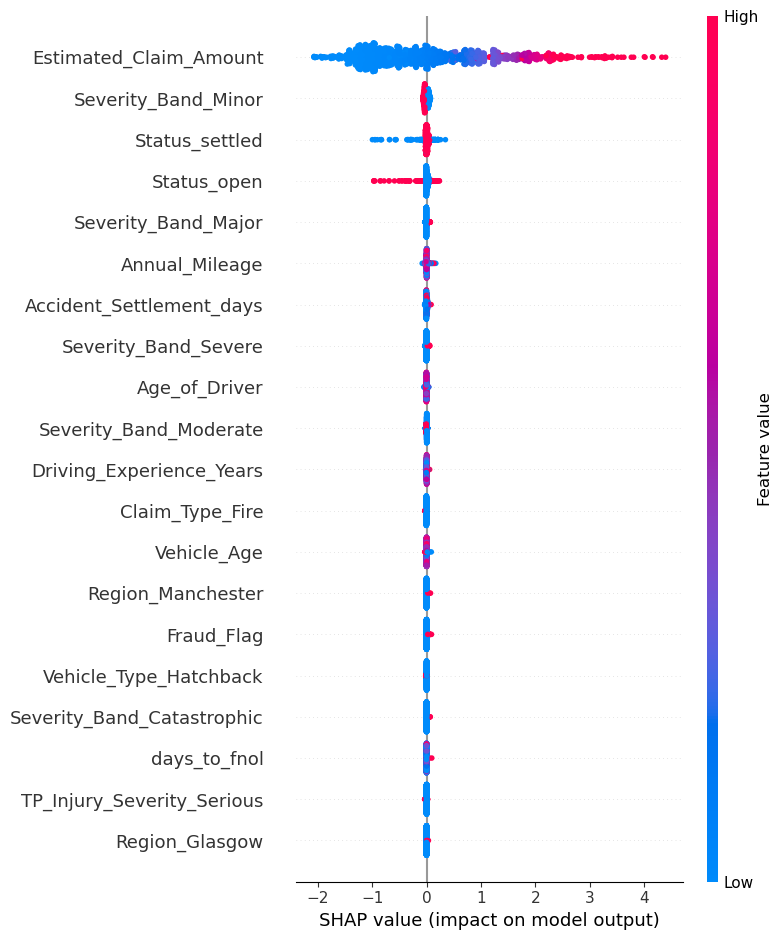

In [31]:
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)


Individual claim explanation

In [32]:
type(shap_values)

numpy.ndarray

In [33]:
# If shap_values is an Explanation object
shap_vals = shap_values


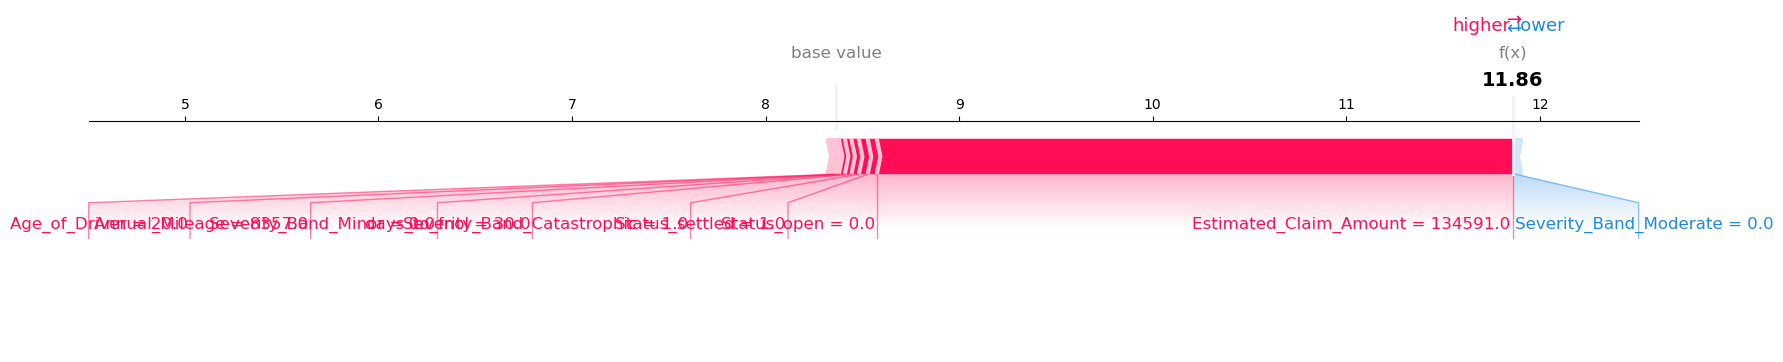

In [34]:
# If shap_values is an Explanation object
#shap_vals = shap_values
#type(shap_values)


i = 0  # claim index

shap.force_plot(
    explainer.expected_value,
    shap_vals[i],
    X_test_transformed.iloc[i],
    feature_names=feature_names,
    matplotlib=True
)


QUANTILE COVERAGE TESTING (P50 / P75 / P90)
What we’re doing

We verify whether:

50% of actuals fall below P50

75% fall below P75

90% fall below P90

Why it matters

Ensures reserve adequacy

Demonstrates calibration

Required for actuarial sign-off

In [35]:
def quantile_coverage(y_true, y_pred):
    return np.mean(y_true <= y_pred)


In [36]:
# Use .values.ravel() to bridge from Pandas to a flat NumPy array
actuals = np.expm1(y_test).values.ravel() 

coverage_results = {}

for q, pipe in quantile_models.items():
    # pipe.predict(X_test) usually returns a numpy array already
    # but we ravel() it just to be 100% safe
    preds = np.expm1(pipe.predict(X_test)).ravel()
    
    # This will now pass into your function as two clean 1D arrays
    coverage_results[f"P{int(q*100)}"] = quantile_coverage(actuals, preds)

print(coverage_results)

{'P50': np.float64(0.4741532976827095), 'P75': np.float64(0.7278669043374926), 'P90': np.float64(0.8835412953060012)}


In [37]:
coverage_df = pd.DataFrame.from_dict(
    coverage_results, orient="index", columns=["Coverage"]
)
coverage_df


,Coverage
P50,0.474153
P75,0.727867
P90,0.883541


PRODUCTION FASTAPI APP (PIPELINE-BASED)

File: app/main.py

Why this design

- One pipeline object

- No manual preprocessing

- Safe against schema drift

FastAPI dependencies to download

- pip install fastapi uvicorn joblib pydantic

- py -m pip install pandas joblib fastapi uvicorn pydantic scikit-learn


In [38]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import pandas as pd
import numpy as np

app = FastAPI(title="GMA Claims Reserve API")

model = joblib.load("C:/Users/HP/Desktop/Dafe/DS_Projects/FNOL_Insurance/models/final_reserving_pipeline.pkl")


In [39]:
# Request Schema


class ClaimInput(BaseModel):
    driver_age: int
    driving_experience: int
    vehicle_age: int
    claim_type: str
    number_of_third_parties: int
    injury_severity: str


In [40]:
# Prediction Endpoint


@app.post("/predict")
def predict_reserve(data: ClaimInput):
    df = pd.DataFrame([data.dict()])

    log_pred = model.predict(df)[0]
    reserve = float(np.expm1(log_pred))

    return {
        "predicted_reserve": round(reserve, 2)
    }


py -m uvicorn app.main:app --reload